In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload

import matplotlib.pyplot as plt
import numpy
import astrohack_projections

# build a kind of galaxy and project it onto x,y,z
gal_model_A = astrohack_projections.galaxy_model_3d()

running_y_vec = numpy.arange(-10, 2, 0.3)
running_x_vec = 10 * numpy.sin(running_y_vec/3.0)
running_cov_vec = (11 - numpy.abs(running_y_vec))/11.0
running_alpha_vec = numpy.exp(11 - numpy.abs(running_y_vec))

for i in xrange(len(running_y_vec)):
    gal_model_A.add_gaussian(float(running_alpha_vec[i]), 
                           numpy.array((running_x_vec[i], running_y_vec[i], 0)), 
                           numpy.eye(3) * running_cov_vec[i])
gal_model_A = gal_model_A * 0.001

gal_model_B = astrohack_projections.galaxy_model_3d()

scale = 4.
gal_model_B.add_gaussian(10.0, numpy.array((0.0, 0.0, 0.0)), numpy.array((1., 0, 0, 0, 2., 0, 0, 0, 3.)).reshape((3, 3)) * scale)
gal_model_B.add_gaussian(1.0, numpy.array((0.0, 0.0, 0.0)), numpy.eye(3) * 0.25 * scale)
gal_model_B.add_gaussian(1.0, numpy.array((0.0, 2.0, 2.0)), numpy.eye(3) * 0.25 * scale)
print type(gal_model_A.get_total_mass())

gal_model_B = gal_model_B * (2. * gal_model_A.get_total_mass() / gal_model_B.get_total_mass())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<type 'numpy.float64'>


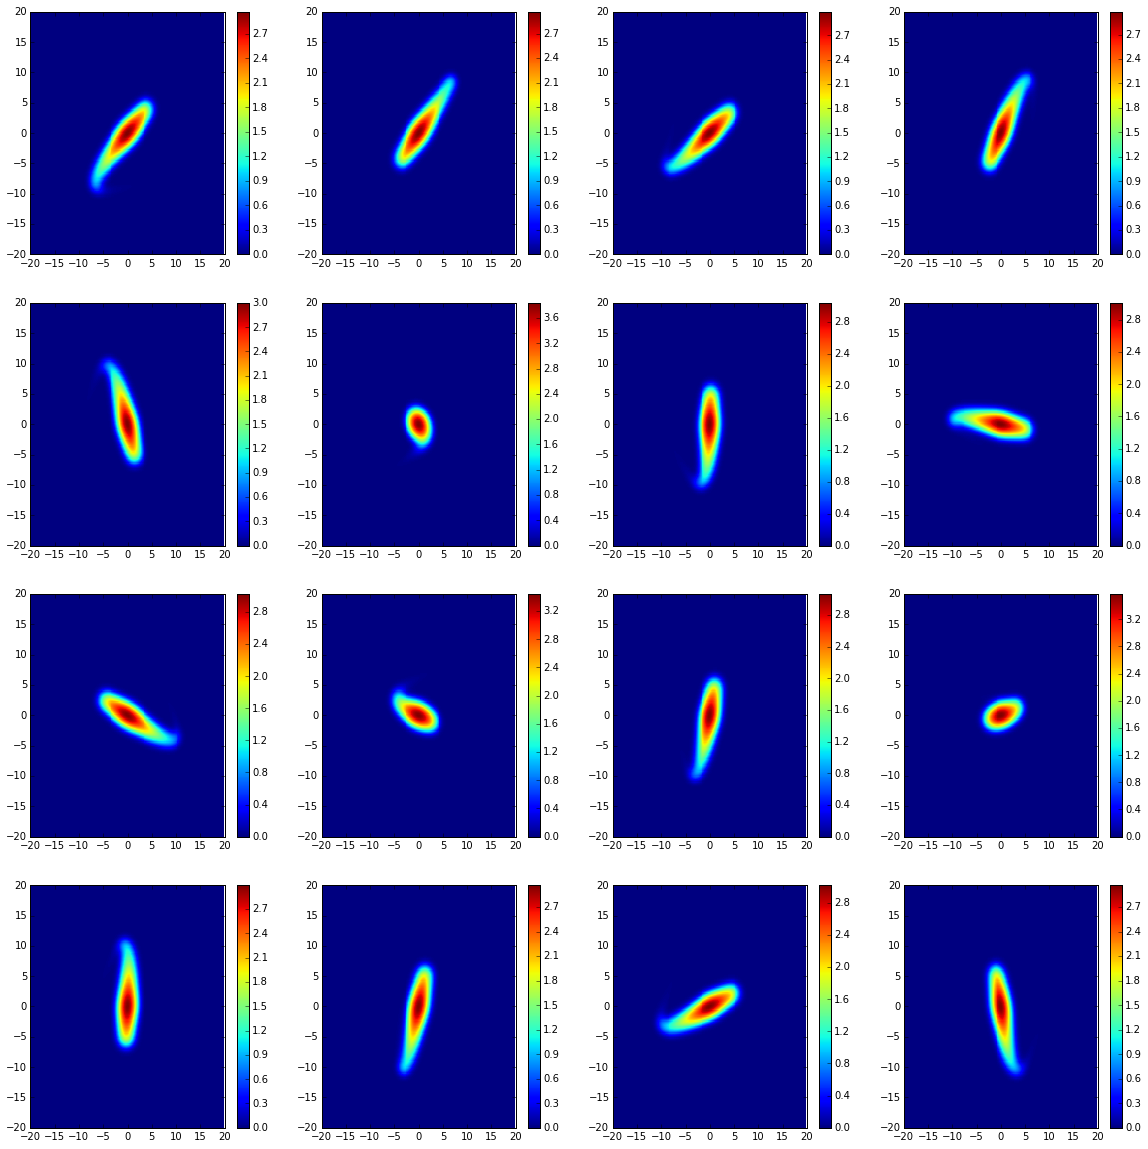

In [13]:
plt.rcParams['figure.figsize'] = 20, 20

# now do the projection 
xs = numpy.arange(-20, 20, 0.2)
ys = numpy.arange(-20, 20, 0.2)
X, Y = numpy.meshgrid(xs, ys)

# plot the same galaxy but with different rotation values
x_angles = numpy.array((0.0, 30.0, 60.0, 90.0))
y_angles = numpy.array((0.0, 30.0, 60.0, 90.0))

for i, x_angle in enumerate(x_angles):
    for j, y_angle in enumerate(y_angles):
        xi_hat, eta_hat = astrohack_projections.choose_random_projection()
        densities = gal_model_A.render_2d_image(xi_hat, eta_hat, xs, ys)
        
        plt.subplot(len(x_angles), len(y_angles), 4*i + j + 1)
        plt.pcolormesh(X, Y, numpy.log1p(densities))
        plt.colorbar()
        #plt.show()

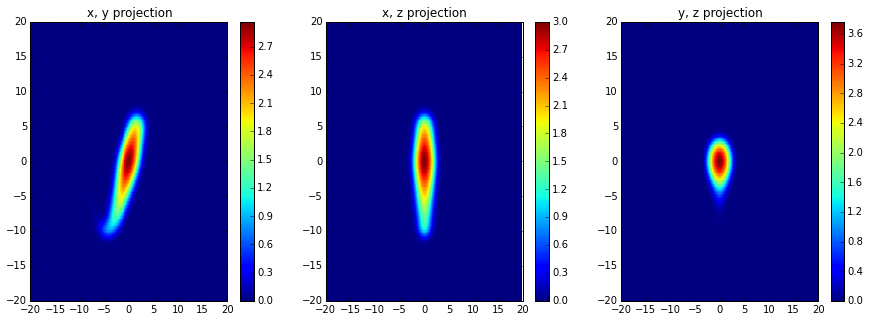

In [14]:
plt.rcParams['figure.figsize'] = 15,5

# plot the projections
plt.subplot(1, 3, 1)
xi_hat = numpy.array((1, 0, 0))
eta_hat = numpy.array((0, 1, 0))
densities = gal_model_A.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.pcolormesh(X, Y, numpy.log1p(densities))
plt.colorbar()
plt.title("x, y projection")

plt.subplot(1, 3, 2)
xi_hat = numpy.array((1, 0, 0))
eta_hat = numpy.array((0, 0, 1))
densities = gal_model_A.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.pcolormesh(X, Y, numpy.log1p(densities))
plt.colorbar()
plt.title("x, z projection")

plt.subplot(1, 3, 3)
xi_hat = numpy.array((0, 1, 0))
eta_hat = numpy.array((0, 0, 1))
densities = gal_model_A.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.pcolormesh(X, Y, numpy.log1p(densities))
plt.colorbar()
plt.title("y, z projection")

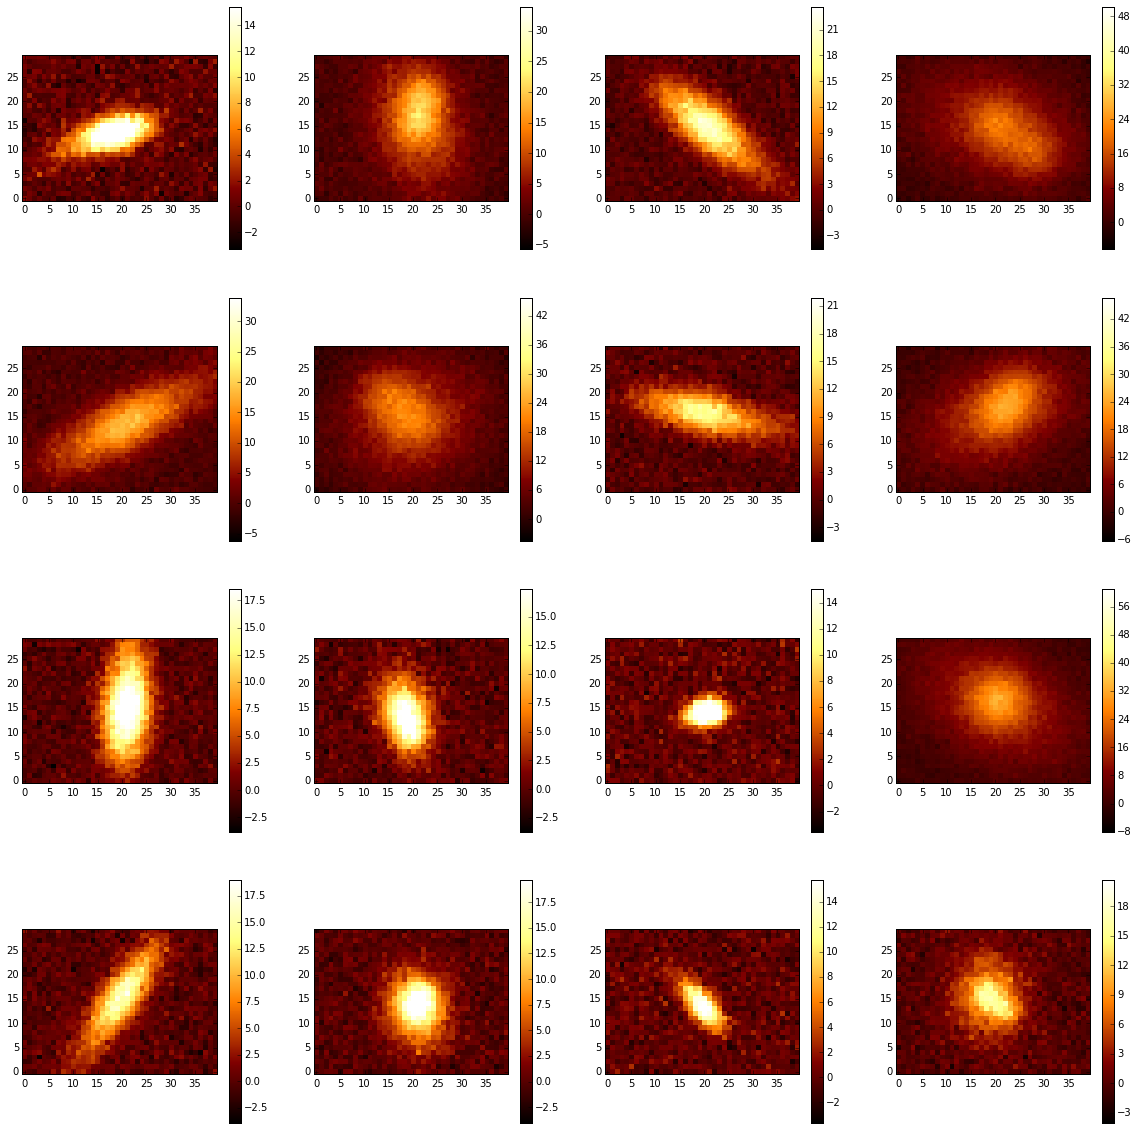

In [16]:
plt.rcParams['figure.figsize'] = 20, 20

# now do the projection 
xs = numpy.arange(-20, 20, 0.2)
ys = numpy.arange(-20, 20, 0.2)
Y, X = numpy.meshgrid(ys, xs)

# plot the same galaxy but with different rotation values
x_angles = numpy.array((0.0, 30.0, 60.0, 90.0))
y_angles = numpy.array((0.0, 30.0, 60.0, 90.0))

plot_kwargs = {"interpolation": "nearest",
          "cmap": "afmhot",
          "origin": "lower"}

psf = astrohack_projections.mixture_of_gaussians(2)
psf.add_gaussian(1., numpy.array([0., 0.]), numpy.eye(2)*1.)

numpy.random.seed(42)
images = []
for i, x_angle in enumerate(x_angles):
    for j, y_angle in enumerate(y_angles):
        
        alpha, beta, gamma = numpy.random.uniform(0.0, 360.0, size=3)
        
        intensity = 1.
        scale = 0.25 * numpy.exp(numpy.random.uniform())
        xshift = numpy.random.uniform(13., 16.)
        yshift = numpy.random.uniform(18., 21.)
        
        image = astrohack_projections.image_and_model()
        image.set_shape((30, 40))
        if j % 2 == 0:
            gal = gal_model_A
        else:
            gal = gal_model_B

        image.set_psf(psf)
        kwargs = {'alpha':alpha, 'beta':beta, 'gamma':gamma, 'intensity':intensity, 'scale':scale, 'xshift': xshift, 'yshift': yshift, 'bg':0.0}
        image.set_parameters(**kwargs)
        image.set_galaxy(gal)
        image.set_ivar(numpy.ones(image.get_shape()))
        image.construct_synthetic()
        image.set_data(image.get_synthetic() + numpy.random.normal(size=image.get_shape()) / numpy.sqrt(image.ivar))

        a, mid = numpy.percentile(image.get_data(), [25., 50.])
        ran = mid - a
        vmin = mid - 5. * ran
        vmax = mid + 20. * ran
        
        plt.subplot(len(x_angles), len(y_angles), 4*i + j + 1)
        plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
        images.append(image)
        plt.colorbar()
        

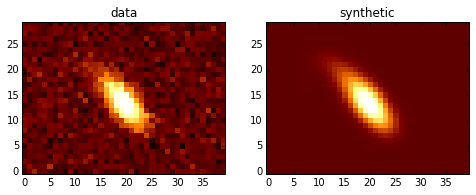

In [5]:
plt.rcParams['figure.figsize'] = 8, 4

ii=14

def showme(img):
    a, mid = numpy.percentile(img.get_data(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    plt.subplot(1, 2, 1)
    plt.title("data")
    plt.imshow(img.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
    plt.subplot(1, 2, 2)
    plt.title("synthetic")
    plt.imshow(img.get_synthetic(), vmin=vmin, vmax=vmax, **plot_kwargs)

showme(images[ii])

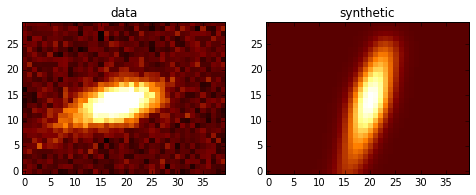

In [20]:
plt.rcParams['figure.figsize'] = 8, 4

# alpha, beta, gamma, intensity, scale, xshift, yshift, bg = pars
ii = 0
pars = (10., 0., 0., 1., 0.5, 14., 20., 0.)
thisimage = images[ii]
thisimage(pars)
showme(thisimage)

plt.savefig("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/fitting_pngs/phase1_init.png")

BEFORE 17574.8267809
AFTER 1162.58733898


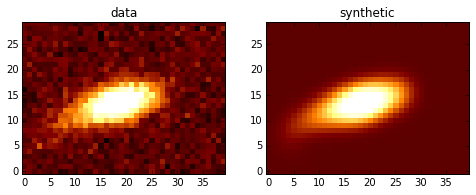

In [21]:
import scipy.optimize as op

pars_0 = (10., 30., 30., 0.1, 0.5, 14., 20., 0.)
thisimage.set_galaxy(gal_model_A)
print "BEFORE", thisimage(pars_0)
result = op.minimize(thisimage, pars_0)
pars = result["x"]
print "AFTER", thisimage(pars) # must run this before showme()

showme(thisimage)
plt.savefig("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/fitting_pngs/phase1_fit.png")

BEFORE 6032.37812792
AFTER 1508.32198399


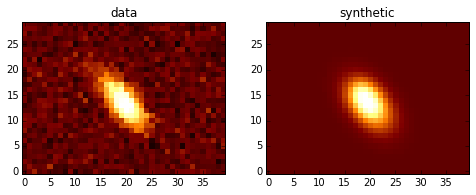

In [8]:
pars_0 = (10., 30., 30., 0.1, 0.5, 14., 20., 0.) # total crap!
thisimage.set_galaxy(gal_model_B)

print "BEFORE", thisimage(pars_0)
result = op.minimize(thisimage, pars_0)
pars = result["x"]
print "AFTER", thisimage(pars)

showme(thisimage)

before A 19773.401916
after A 1162.587339
before B 19618.0374857
after B 1785.94606901
0 BEST MODEL IS A
before A 47720.4617539
after A 1652.77088538
before B 47377.5980333
after B 1159.24295455
1 BEST MODEL IS B
before A 34832.778635
after A 1771.6095654
before B 34479.8700828
after B 3058.09937238
2 BEST MODEL IS A
before A 82112.9302077
after A 2103.51746686
before B 81652.959613
after B 1160.92286102
3 BEST MODEL IS B
before A 44489.8693971
after A 1393.82137498
before B 44271.1835922
after B 4362.92372727
4 BEST MODEL IS A
before A 91747.910527
after A 2112.25708652
before B 91294.5728693
after B 2705.8768968
5 BEST MODEL IS A
before A 22448.295295
after A 1538.47824904
before B 22211.5980616
after B 3412.49765601
6 BEST MODEL IS A
before A 80315.3504878
after A 1666.16939618
before B 79946.0896414
after B 1144.28998493
7 BEST MODEL IS B
before A 36994.2744267
after A 1285.31968948
before B 36689.9449414
after B 2546.54856539
8 BEST MODEL IS A
before A 20984.3131995
after A 1403.5

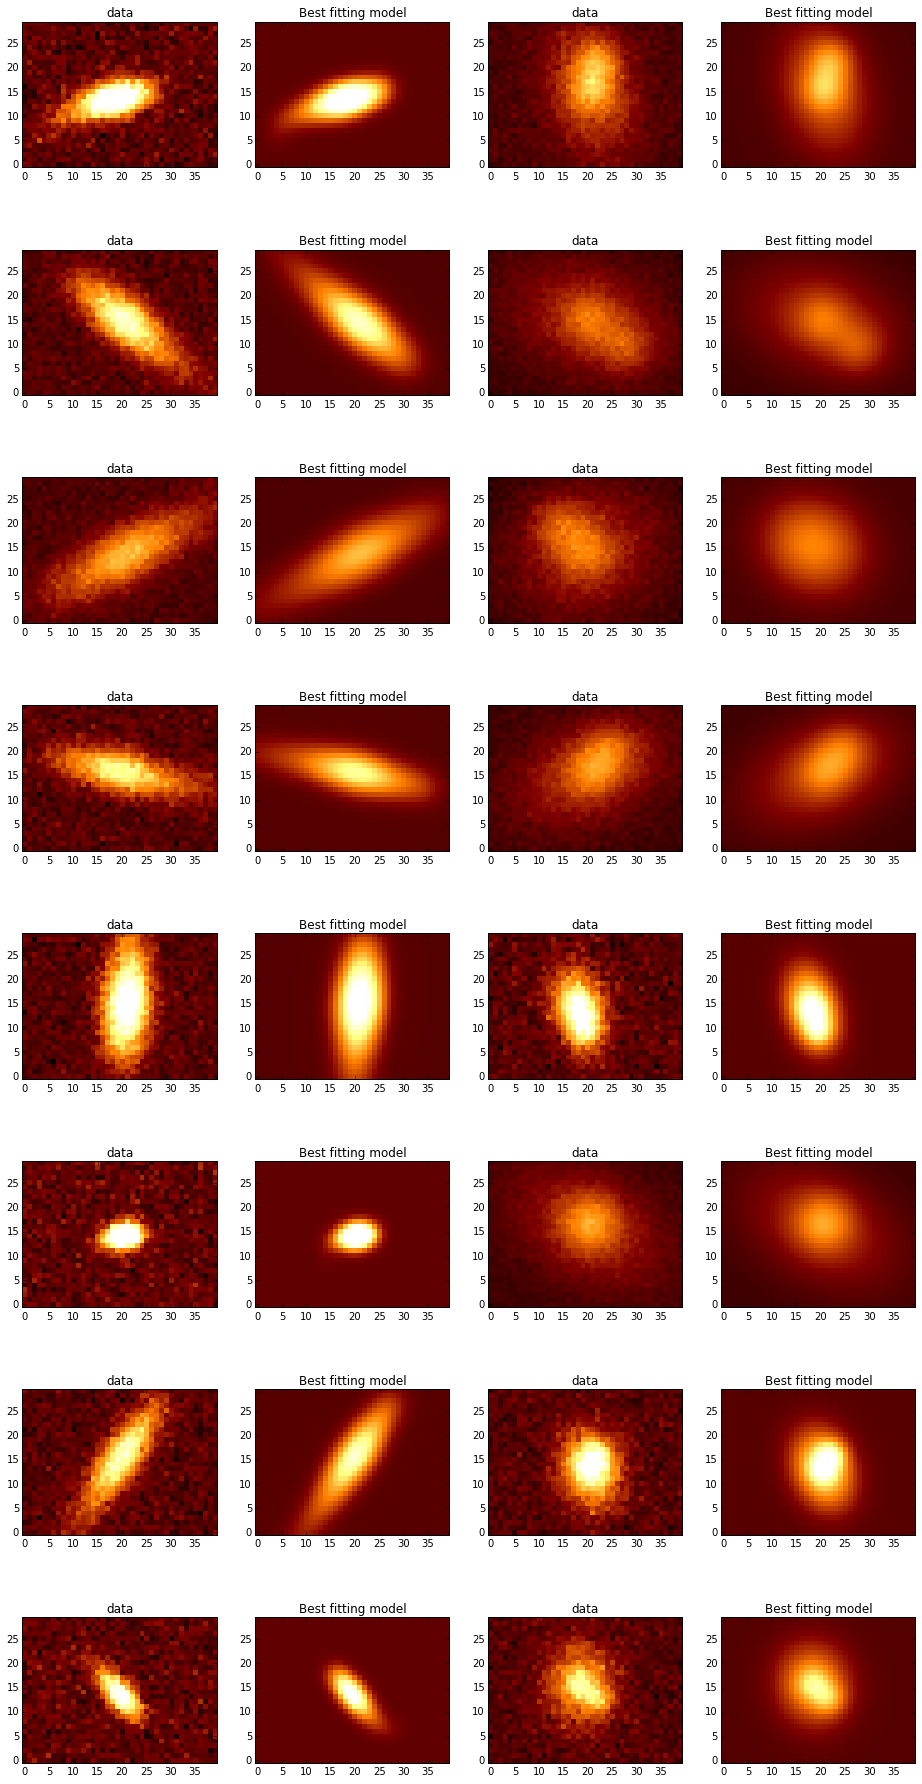

In [9]:
plt.rcParams['figure.figsize'] = 4 * 4, 4 * 8
import scipy.optimize as op

pars_0 = (10., 30., 30., 0.01, 0.5, 14., 20., 0.)

for ii in range(16):
    thisimage = images[ii]
    bestchisquared = numpy.Inf
    
    for model, name in [(gal_model_A, "A"), (gal_model_B, "B")]:
        thisimage.set_galaxy(model)
        print "before", name, thisimage(pars_0)
        result = op.minimize(thisimage, pars_0)
        pars = result["x"]
        chisquared = thisimage(pars)
        print "after", name, chisquared
        if chisquared < bestchisquared:
            bestname = name
            bestmodel = model
            bestchisquared = chisquared
            bestpars = pars
    print ii, "BEST MODEL IS", bestname
    
    # plot
    a, mid = numpy.percentile(thisimage.get_data(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    index = 2 * ii + 1
    
    plt.subplot(8, 4, index)
    plt.title("data")
    plt.imshow(thisimage.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
    plt.subplot(8, 4, index+1)
    thisimage.set_galaxy(bestmodel)
    thisimage(bestpars)
    plt.title("Best fitting model")
    plt.imshow(thisimage.get_synthetic(), vmin=vmin, vmax=vmax, **plot_kwargs)
    

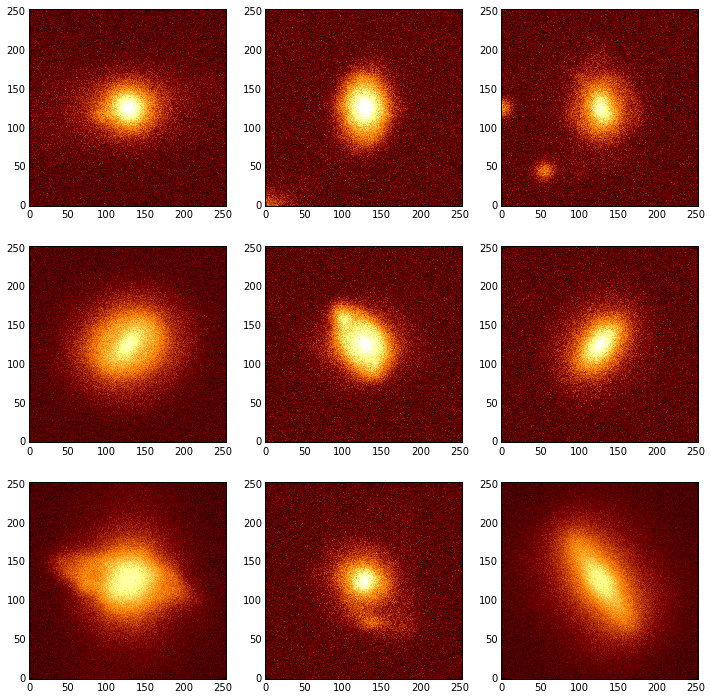

In [10]:

plt.rcParams['figure.figsize'] = 12, 12

# plot a sample of Illustris galaxies
import glob
import matplotlib.image as mpimg
from scipy.ndimage.filters import gaussian_filter

g = glob.glob("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/*.png")

psf = astrohack_projections.mixture_of_gaussians(2)
psf.add_gaussian(1., numpy.array([0., 0.]), numpy.eye(2)*1.)

for i,path in enumerate(g):
    data = mpimg.imread(path)
    data_sum = numpy.sum(data, axis=2)
    # psf the data manually since we don't have an actual convolve model
    data_sum = gaussian_filter(data_sum, 5)
    
    image = astrohack_projections.image_and_model()
    image.set_ivar(numpy.ones(data_sum.shape) * 50)
    image.set_data(data_sum + numpy.random.normal(size=data_sum.shape) / numpy.sqrt(image.ivar))

    
    a, mid = numpy.percentile(image.get_data(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)

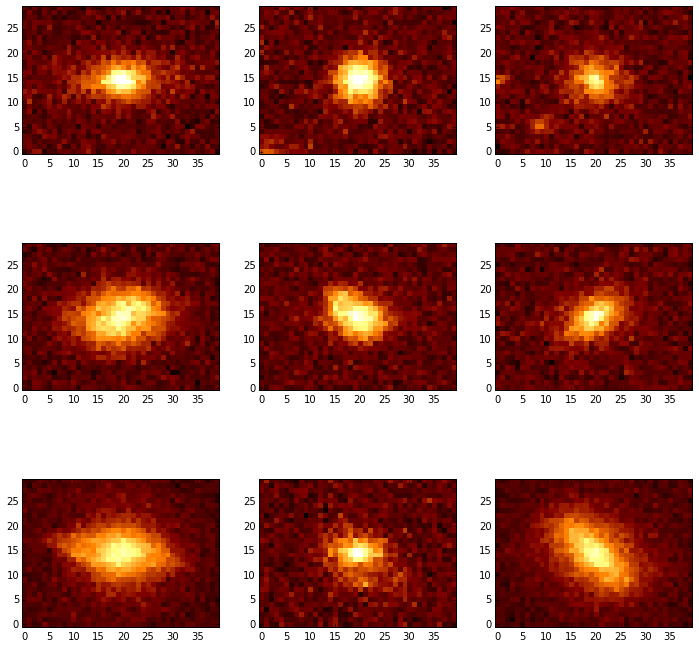

In [11]:
plt.rcParams['figure.figsize'] = 12, 12#8, 4*9

from scipy.ndimage.interpolation import zoom

g = glob.glob("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/*.png")

psf = astrohack_projections.mixture_of_gaussians(2)
psf.add_gaussian(1., numpy.array([0., 0.]), numpy.eye(2)*1.)

for i,path in enumerate(g):
    data = mpimg.imread(path)
    data_sum = numpy.sum(data, axis=2)
    # psf the data manually since we don't have an actual convolve model
    data_sum = gaussian_filter(data_sum, 5)
    # manually change its shape to fit the shape of the models
    d_factors = [30.0/data_sum.shape[0], 40.0/data_sum.shape[1]]
    d = zoom(data_sum, d_factors)
    
    image = astrohack_projections.image_and_model()
    image.set_ivar(numpy.ones(d.shape) * 50)
    image.set_data(d + numpy.random.normal(size=d.shape) / numpy.sqrt(image.ivar))

    a, mid = numpy.percentile(image.get_data(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)

In [ ]:
plt.rcParams['figure.figsize'] = 8, 4*9


g = glob.glob("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/*.png")   
pars_0 = (10., 30., 30., 0.001, 0.5, 14., 20., 0.)
psf = astrohack_projections.mixture_of_gaussians(2)
psf.add_gaussian(1., numpy.array([0., 0.]), numpy.eye(2)*1.)

for ii,path in enumerate(g):
    
    ############################################### IMAGE ####################################################
    data = mpimg.imread(path)
    data_sum = numpy.sum(data, axis=2)
    # psf the data manually since we don't have an actual convolve model
    data_sum = gaussian_filter(data_sum, 2) # WARNING: This needs to be synchronized with above and below??
    # manually change its shape to fit the shape of the models
    d_factors = [30.0/data_sum.shape[0], 40.0/data_sum.shape[1]]
    d = zoom(data_sum, d_factors)
    sigma = 1. / 7.
    d += sigma * numpy.random.normal(size=d.shape) # add noise
    
    thisimage = astrohack_projections.image_and_model()
    thisimage.set_data(d)
    thisimage.set_ivar(numpy.zeros(image.get_shape()) + 1. / (sigma * sigma))
    thisimage.set_psf(psf)

    ############################################### FIT #####################################################    
    
    bestchisquared = numpy.Inf
    
    for model, name in [(gal_model_A, "A"), (gal_model_B, "B")]:
        thisimage.set_galaxy(model)
        print "before", name, thisimage(pars_0)
        result = op.minimize(thisimage, pars_0)
        pars = result["x"]
        chisquared = thisimage(pars)
        print "after", name, chisquared
        if chisquared < bestchisquared:
            bestname = name
            bestmodel = model
            bestchisquared = chisquared
            bestpars = pars
    print ii, "BEST MODEL IS", bestname    
    
    a, mid = numpy.percentile(thisimage.get_data(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    index = 2 * ii + 1
    
    plt.subplot(9, 2, index)
    plt.title("data")
    plt.imshow(thisimage.get_data(), **plot_kwargs)
    
    a, mid = numpy.percentile(thisimage.get_synthetic(), [25., 50.])
    ran = mid - a
    vmin = mid - 5. * ran
    vmax = mid + 20. * ran
    index = 2 * ii + 1
    
    plt.subplot(9, 2, index+1)
    thisimage.set_galaxy(bestmodel)
    thisimage(bestpars)
    plt.title("Best fitting model")
    plt.imshow(thisimage.get_synthetic(), **plot_kwargs)    
